## Classifying Bad Product Reviews: Deep Learning Model

### Organize imports

In [1]:
from gensim.models import Word2Vec
from lib.amazon_model import *
from lib.data_mgmt import *
from nltk.data import find
from sklearn.metrics import roc_curve, auc

import gensim
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

%load_ext autoreload
%autoreload 2
%autosave 5

Autosaving every 5 seconds


### add check in order to see if TensorFlow with GPU is used

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13985967567059410333, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15770815693
 locality {
   bus_id: 1
 }
 incarnation: 9356014460632071977
 physical_device_desc: "device: 0, name: Quadro P5000, pci bus id: 0000:02:00.0, compute capability: 6.1"]

### Set network parameters

In [3]:
# Dataset/Featurization Config
path = 'data/full_cols_bad_50k.csv'
label = 'bad'
max_size = 200
max_tfidf = 12000
n_classes = 2
n_features = 300
test_size = 0.25
verbose = True

# LSTM Config
lstm_size = 50
num_lstm_layers = 2
lstm_dropout = 0.15

# FC Config
fc_layer_sizes = [75, 50, 30]
fc_dropout = 0.10

# Training config
run_name = label + '_run_' + path.split('.')[0].split('_')[-1]
learning_rate = 1e-3
reg_weight = 1e-5
training_iters = 15000 * 10
batch_size = 15
display_step = 10
save_every = 5000
save_fn = 'chkpts/model_' + run_name + '.ckpt'
should_log_metrics = True

In [4]:
training_loss_iter_fn = 'log/training_loss_iter_' + run_name + '.csv'
training_acc_iter_fn = 'log/training_acc_iter_' + run_name + '.csv'
testing_loss_iter_fn = 'log/testing_loss_iter_' + run_name + '.csv'
testing_acc_iter_fn = 'log/testing_acc_iter_' + run_name + '.csv'

### Set up word embedding model

In [5]:
%%time
word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
we_model = gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)

CPU times: user 8.36 s, sys: 172 ms, total: 8.53 s
Wall time: 8.54 s


### Configure dataset

In [6]:
%%time
dataset = Dataset(path, we_model, {
    'label'      : label,
    'max_size'   : max_size,
    'max_tfidf'  : max_tfidf,
    'n_features' : n_features,
    'test_size'  : test_size,
    'verbose'    : verbose
})

n_cols = dataset.get_n_cols() # Number of additional DNN features (including tf-idf features)

Initializing dataset at data/full_cols_bad_50k.csv.
Splitting training and test sets.
Building reviewer/ASIN maps.
Fitting tf-idf featurizer.
doc list created: 50000
Tuning tf-idf classifier.


/u/44/prollm1/unix/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


Featurizing training set.
Featurizing test set.
Finished configuring dataset.
CPU times: user 31min 11s, sys: 1min 24s, total: 32min 35s
Wall time: 6min 26s


### Prepare model configurations

In [7]:
class ModelConfig(object):
    def __init__(self):
        self.lstm_size = lstm_size
        self.num_lstm_layers = num_lstm_layers
        self.lstm_keep_prob = 1.0 - lstm_dropout
        self.fc_keep_prob = 1.0 - fc_dropout
        self.learning_rate = learning_rate
        self.reg_weight = reg_weight
        self.fc_layer_sizes = fc_layer_sizes
        self.n_classes = n_classes
        self.n_cols = n_cols
        self.n_fc_layers = len(fc_layer_sizes) + 1

config = ModelConfig()

### Set up Tensorflow Graph

In [8]:
tf.reset_default_graph()

amazon_model = AmazonModel(config)
pred = amazon_model.build_graph()

In [9]:
# Input placeholders
x = tf.placeholder("float", [None, max_size, n_features])
x2 = tf.placeholder("float", [None, n_cols])
seqlen = tf.placeholder(tf.int32, [None])
lstm_keep_prob = tf.placeholder(tf.float32)
fc_keep_prob = tf.placeholder(tf.float32)

# Output placeholder
y = tf.placeholder("float", [None, n_classes])

# Checkpointing
saver = tf.train.Saver()

In [10]:
# Run forward pass
logits, weights = pred(x, x2, seqlen, lstm_keep_prob, fc_keep_prob)

# Define loss and optimizer
cost = tf.add(tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)),
              amazon_model.regularization_penalty())

optimizer = tf.train.AdamOptimizer(learning_rate=config.learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(logits,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

/u/44/prollm1/unix/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [11]:
# Initializing the variables
init = tf.global_variables_initializer()

### Train model

In [12]:
if should_log_metrics:
    train_loss_log = open(training_loss_iter_fn, 'a')
    test_loss_log = open(testing_loss_iter_fn, 'a')
    train_acc_log = open(training_acc_iter_fn, 'a')
    test_acc_log = open(testing_acc_iter_fn, 'a')

Iter 150, Minibatch Loss= 0.683445, Training Accuracy= 0.40000
Iter 300, Minibatch Loss= 0.685622, Training Accuracy= 0.60000
Iter 450, Minibatch Loss= 0.636480, Training Accuracy= 0.60000
Iter 600, Minibatch Loss= 0.628535, Training Accuracy= 0.53333
Iter 750, Minibatch Loss= 0.657455, Training Accuracy= 0.53333
Validation Accuracy: 0.65904
Validation Loss: 0.6555177


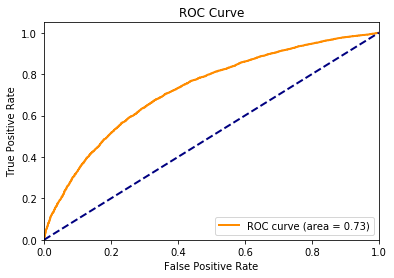

Iter 900, Minibatch Loss= 0.622623, Training Accuracy= 0.73333
Iter 1050, Minibatch Loss= 0.594443, Training Accuracy= 0.73333
Iter 1200, Minibatch Loss= 0.667793, Training Accuracy= 0.66667
Iter 1350, Minibatch Loss= 0.609120, Training Accuracy= 0.60000
Iter 1500, Minibatch Loss= 0.746831, Training Accuracy= 0.73333
Validation Accuracy: 0.6508
Validation Loss: 0.65377426
Iter 1650, Minibatch Loss= 0.717012, Training Accuracy= 0.60000
Iter 1800, Minibatch Loss= 0.622110, Training Accuracy= 0.86667
Iter 1950, Minibatch Loss= 0.498381, Training Accuracy= 0.86667
Iter 2100, Minibatch Loss= 0.557945, Training Accuracy= 0.66667
Iter 2250, Minibatch Loss= 0.585304, Training Accuracy= 0.80000
Validation Accuracy: 0.67112
Validation Loss: 0.6207261


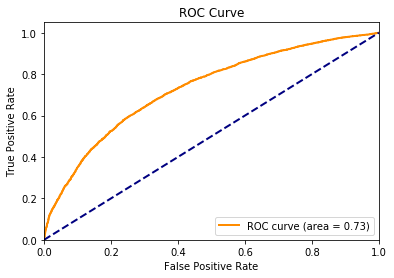

Iter 2400, Minibatch Loss= 0.674764, Training Accuracy= 0.60000
Iter 2550, Minibatch Loss= 0.641531, Training Accuracy= 0.66667
Iter 2700, Minibatch Loss= 0.715217, Training Accuracy= 0.53333
Iter 2850, Minibatch Loss= 0.566886, Training Accuracy= 0.80000
Iter 3000, Minibatch Loss= 0.644050, Training Accuracy= 0.53333
Validation Accuracy: 0.6684
Validation Loss: 0.62306625
Iter 3150, Minibatch Loss= 0.665767, Training Accuracy= 0.66667
Iter 3300, Minibatch Loss= 0.489378, Training Accuracy= 0.86667
Iter 3450, Minibatch Loss= 0.727513, Training Accuracy= 0.53333
Iter 3600, Minibatch Loss= 0.613927, Training Accuracy= 0.66667
Iter 3750, Minibatch Loss= 0.592031, Training Accuracy= 0.73333
Validation Accuracy: 0.674
Validation Loss: 0.6149967


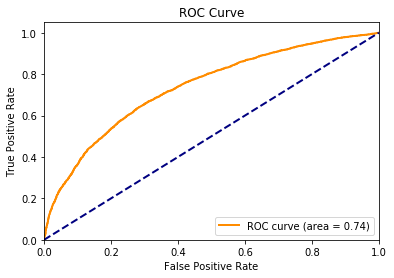

Iter 3900, Minibatch Loss= 0.609378, Training Accuracy= 0.60000
Iter 4050, Minibatch Loss= 0.526507, Training Accuracy= 0.86667
Iter 4200, Minibatch Loss= 0.658491, Training Accuracy= 0.60000
Iter 4350, Minibatch Loss= 0.574751, Training Accuracy= 0.93333
Iter 4500, Minibatch Loss= 0.617171, Training Accuracy= 0.60000
Validation Accuracy: 0.67536
Validation Loss: 0.6133977


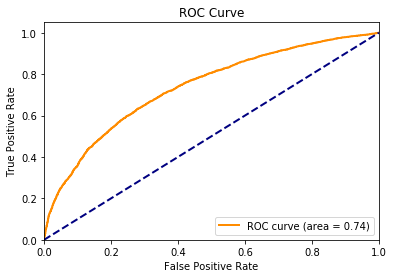

Iter 4650, Minibatch Loss= 0.591385, Training Accuracy= 0.73333
Iter 4800, Minibatch Loss= 0.591179, Training Accuracy= 0.60000
Iter 4950, Minibatch Loss= 0.623177, Training Accuracy= 0.60000
Iter 5100, Minibatch Loss= 0.571210, Training Accuracy= 0.73333
Iter 5250, Minibatch Loss= 0.511528, Training Accuracy= 0.86667
Validation Accuracy: 0.68288
Validation Loss: 0.6071561


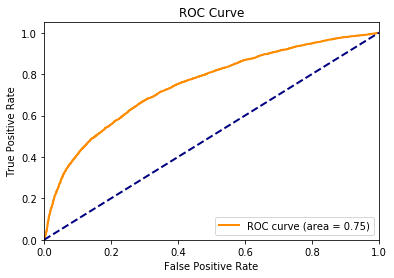

Iter 5400, Minibatch Loss= 0.552062, Training Accuracy= 0.73333
Iter 5550, Minibatch Loss= 0.681809, Training Accuracy= 0.46667
Iter 5700, Minibatch Loss= 0.625683, Training Accuracy= 0.73333
Iter 5850, Minibatch Loss= 0.591018, Training Accuracy= 0.80000
Iter 6000, Minibatch Loss= 0.792070, Training Accuracy= 0.53333
Validation Accuracy: 0.67896
Validation Loss: 0.6072488
Iter 6150, Minibatch Loss= 0.607443, Training Accuracy= 0.60000
Iter 6300, Minibatch Loss= 0.806410, Training Accuracy= 0.53333
Iter 6450, Minibatch Loss= 0.584894, Training Accuracy= 0.46667
Iter 6600, Minibatch Loss= 0.598647, Training Accuracy= 0.60000
Iter 6750, Minibatch Loss= 0.626071, Training Accuracy= 0.60000
Validation Accuracy: 0.68848
Validation Loss: 0.6069258


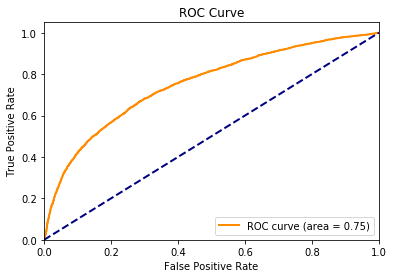

Iter 6900, Minibatch Loss= 0.618046, Training Accuracy= 0.80000
Iter 7050, Minibatch Loss= 0.522572, Training Accuracy= 0.80000
Iter 7200, Minibatch Loss= 0.634009, Training Accuracy= 0.66667
Iter 7350, Minibatch Loss= 0.490264, Training Accuracy= 0.66667
Iter 7500, Minibatch Loss= 0.545403, Training Accuracy= 0.66667
Validation Accuracy: 0.69168
Validation Loss: 0.60669845


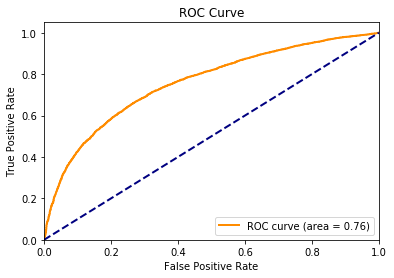

Iter 7650, Minibatch Loss= 0.555882, Training Accuracy= 0.80000
Iter 7800, Minibatch Loss= 0.447668, Training Accuracy= 0.86667
Iter 7950, Minibatch Loss= 0.798498, Training Accuracy= 0.46667
Iter 8100, Minibatch Loss= 0.571362, Training Accuracy= 0.60000
Iter 8250, Minibatch Loss= 0.587273, Training Accuracy= 0.73333
Validation Accuracy: 0.64448
Validation Loss: 0.63247174
Iter 8400, Minibatch Loss= 0.481543, Training Accuracy= 0.86667
Iter 8550, Minibatch Loss= 0.537162, Training Accuracy= 0.66667
Iter 8700, Minibatch Loss= 0.896251, Training Accuracy= 0.60000
Iter 8850, Minibatch Loss= 0.477730, Training Accuracy= 0.86667
Iter 9000, Minibatch Loss= 0.784956, Training Accuracy= 0.60000
Validation Accuracy: 0.71072
Validation Loss: 0.5893666


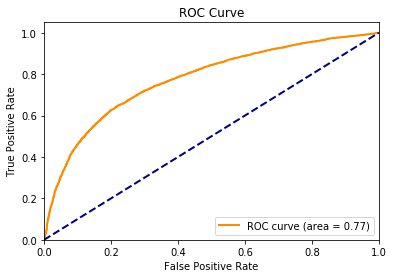

Iter 9150, Minibatch Loss= 0.562056, Training Accuracy= 0.80000
Iter 9300, Minibatch Loss= 0.479012, Training Accuracy= 0.86667
Iter 9450, Minibatch Loss= 0.551254, Training Accuracy= 0.93333
Iter 9600, Minibatch Loss= 0.380207, Training Accuracy= 0.86667
Iter 9750, Minibatch Loss= 0.495112, Training Accuracy= 0.80000
Validation Accuracy: 0.69664
Validation Loss: 0.5884194
Iter 9900, Minibatch Loss= 0.590268, Training Accuracy= 0.73333
Iter 10050, Minibatch Loss= 0.420467, Training Accuracy= 0.73333
Iter 10200, Minibatch Loss= 0.557817, Training Accuracy= 0.66667
Iter 10350, Minibatch Loss= 0.438609, Training Accuracy= 0.86667
Iter 10500, Minibatch Loss= 0.593087, Training Accuracy= 0.73333
Validation Accuracy: 0.68688
Validation Loss: 0.5945539
Iter 10650, Minibatch Loss= 0.416094, Training Accuracy= 0.86667
Iter 10800, Minibatch Loss= 0.400112, Training Accuracy= 0.80000
Iter 10950, Minibatch Loss= 0.733543, Training Accuracy= 0.60000
Iter 11100, Minibatch Loss= 0.712946, Training Ac

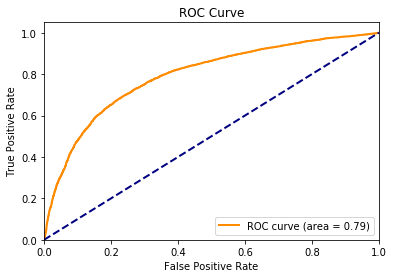

Iter 12150, Minibatch Loss= 0.447371, Training Accuracy= 0.73333
Iter 12300, Minibatch Loss= 0.577127, Training Accuracy= 0.73333
Iter 12450, Minibatch Loss= 0.711925, Training Accuracy= 0.60000
Iter 12600, Minibatch Loss= 0.512207, Training Accuracy= 0.66667
Iter 12750, Minibatch Loss= 0.598665, Training Accuracy= 0.66667
Validation Accuracy: 0.69824
Validation Loss: 0.6179668
Iter 12900, Minibatch Loss= 0.541647, Training Accuracy= 0.80000
Iter 13050, Minibatch Loss= 0.757547, Training Accuracy= 0.73333
Iter 13200, Minibatch Loss= 0.443105, Training Accuracy= 0.86667
Iter 13350, Minibatch Loss= 0.395696, Training Accuracy= 0.86667
Iter 13500, Minibatch Loss= 0.517168, Training Accuracy= 0.66667
Validation Accuracy: 0.72696
Validation Loss: 0.56874096


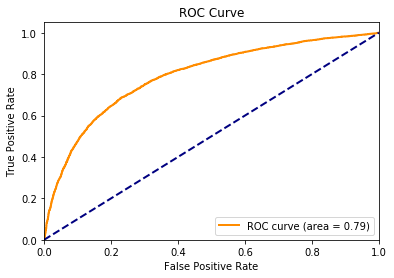

Iter 13650, Minibatch Loss= 0.693395, Training Accuracy= 0.66667
Iter 13800, Minibatch Loss= 0.544179, Training Accuracy= 0.80000
Iter 13950, Minibatch Loss= 0.529378, Training Accuracy= 0.73333
Iter 14100, Minibatch Loss= 0.522291, Training Accuracy= 0.80000
Iter 14250, Minibatch Loss= 0.760739, Training Accuracy= 0.60000
Validation Accuracy: 0.66048
Validation Loss: 0.6861397
Iter 14400, Minibatch Loss= 0.478603, Training Accuracy= 0.80000
Iter 14550, Minibatch Loss= 0.662204, Training Accuracy= 0.53333
Iter 14700, Minibatch Loss= 0.642176, Training Accuracy= 0.73333
Iter 14850, Minibatch Loss= 0.543130, Training Accuracy= 0.86667
Iter 15000, Minibatch Loss= 0.466944, Training Accuracy= 0.86667
Validation Accuracy: 0.7284
Validation Loss: 0.5733626


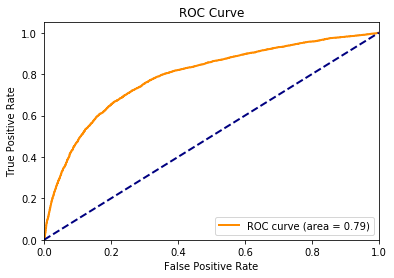

Iter 15150, Minibatch Loss= 0.507749, Training Accuracy= 0.86667
Iter 15300, Minibatch Loss= 0.358465, Training Accuracy= 0.93333
Iter 15450, Minibatch Loss= 0.514468, Training Accuracy= 0.86667
Iter 15600, Minibatch Loss= 0.389656, Training Accuracy= 0.93333
Iter 15750, Minibatch Loss= 0.622955, Training Accuracy= 0.66667
Validation Accuracy: 0.70032
Validation Loss: 0.58166355
Iter 15900, Minibatch Loss= 0.573277, Training Accuracy= 0.73333
Iter 16050, Minibatch Loss= 0.342035, Training Accuracy= 0.93333
Iter 16200, Minibatch Loss= 0.370041, Training Accuracy= 0.86667
Iter 16350, Minibatch Loss= 0.496864, Training Accuracy= 0.80000
Iter 16500, Minibatch Loss= 0.652226, Training Accuracy= 0.66667
Validation Accuracy: 0.70072
Validation Loss: 0.57953364
Iter 16650, Minibatch Loss= 0.460726, Training Accuracy= 0.80000
Iter 16800, Minibatch Loss= 0.618120, Training Accuracy= 0.73333
Iter 16950, Minibatch Loss= 0.554144, Training Accuracy= 0.80000
Iter 17100, Minibatch Loss= 0.447392, Tra

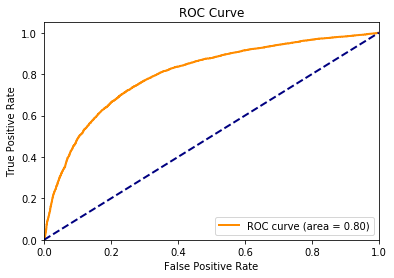

Iter 17400, Minibatch Loss= 0.742854, Training Accuracy= 0.73333
Iter 17550, Minibatch Loss= 0.590683, Training Accuracy= 0.53333
Iter 17700, Minibatch Loss= 0.483986, Training Accuracy= 0.80000
Iter 17850, Minibatch Loss= 0.510808, Training Accuracy= 0.73333
Iter 18000, Minibatch Loss= 0.379805, Training Accuracy= 0.86667
Validation Accuracy: 0.73896
Validation Loss: 0.5639923


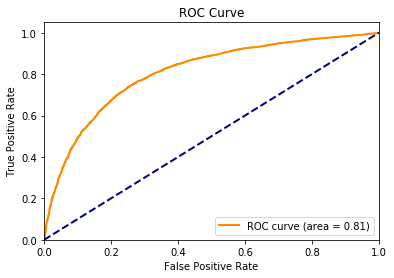

Iter 18150, Minibatch Loss= 0.683893, Training Accuracy= 0.60000
Iter 18300, Minibatch Loss= 0.652954, Training Accuracy= 0.73333
Iter 18450, Minibatch Loss= 0.485947, Training Accuracy= 0.80000
Iter 18600, Minibatch Loss= 0.593313, Training Accuracy= 0.66667
Iter 18750, Minibatch Loss= 0.588364, Training Accuracy= 0.66667
Validation Accuracy: 0.74
Validation Loss: 0.5482291


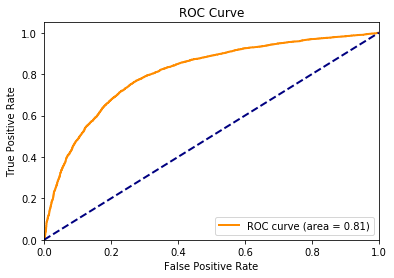

Iter 18900, Minibatch Loss= 0.495313, Training Accuracy= 0.80000
Iter 19050, Minibatch Loss= 0.333038, Training Accuracy= 0.93333
Iter 19200, Minibatch Loss= 0.739513, Training Accuracy= 0.46667
Iter 19350, Minibatch Loss= 0.437944, Training Accuracy= 0.86667
Iter 19500, Minibatch Loss= 0.502579, Training Accuracy= 0.80000
Validation Accuracy: 0.72224
Validation Loss: 0.55610645
Iter 19650, Minibatch Loss= 0.480493, Training Accuracy= 0.80000
Iter 19800, Minibatch Loss= 0.493493, Training Accuracy= 0.80000
Iter 19950, Minibatch Loss= 0.554597, Training Accuracy= 0.73333
Iter 20100, Minibatch Loss= 0.657813, Training Accuracy= 0.66667
Iter 20250, Minibatch Loss= 0.698605, Training Accuracy= 0.73333
Validation Accuracy: 0.73872
Validation Loss: 0.54264766
Iter 20400, Minibatch Loss= 0.499647, Training Accuracy= 0.80000
Iter 20550, Minibatch Loss= 0.541298, Training Accuracy= 0.66667
Iter 20700, Minibatch Loss= 0.459206, Training Accuracy= 0.86667
Iter 20850, Minibatch Loss= 0.495132, Tra

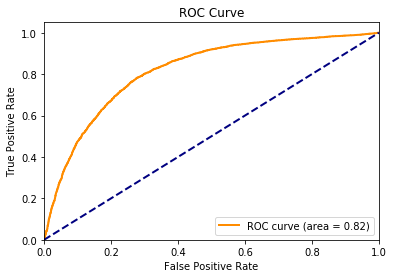

Iter 21150, Minibatch Loss= 0.609431, Training Accuracy= 0.73333
Iter 21300, Minibatch Loss= 0.617476, Training Accuracy= 0.86667
Iter 21450, Minibatch Loss= 0.560994, Training Accuracy= 0.73333
Iter 21600, Minibatch Loss= 0.431150, Training Accuracy= 0.80000
Iter 21750, Minibatch Loss= 0.673586, Training Accuracy= 0.53333
Validation Accuracy: 0.71952
Validation Loss: 0.57667714
Iter 21900, Minibatch Loss= 0.330933, Training Accuracy= 0.93333
Iter 22050, Minibatch Loss= 0.508937, Training Accuracy= 0.73333
Iter 22200, Minibatch Loss= 0.498763, Training Accuracy= 0.66667
Iter 22350, Minibatch Loss= 0.384213, Training Accuracy= 0.86667
Iter 22500, Minibatch Loss= 0.491420, Training Accuracy= 0.80000
Validation Accuracy: 0.73248
Validation Loss: 0.55132246
Iter 22650, Minibatch Loss= 0.419873, Training Accuracy= 0.86667
Iter 22800, Minibatch Loss= 0.504559, Training Accuracy= 0.80000
Iter 22950, Minibatch Loss= 0.816589, Training Accuracy= 0.60000
Iter 23100, Minibatch Loss= 0.431528, Tra

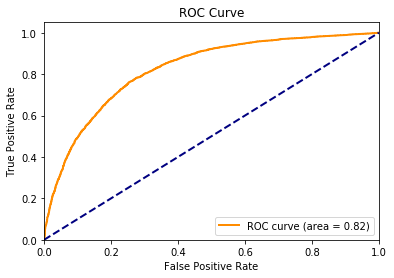

Iter 32400, Minibatch Loss= 0.603086, Training Accuracy= 0.66667
Iter 32550, Minibatch Loss= 0.366024, Training Accuracy= 0.80000
Iter 32700, Minibatch Loss= 0.528639, Training Accuracy= 0.80000
Iter 32850, Minibatch Loss= 0.395653, Training Accuracy= 0.93333
Iter 33000, Minibatch Loss= 0.407498, Training Accuracy= 0.86667
Validation Accuracy: 0.74592
Validation Loss: 0.5281747
Iter 33150, Minibatch Loss= 0.514550, Training Accuracy= 0.73333
Iter 33300, Minibatch Loss= 0.651359, Training Accuracy= 0.73333
Iter 33450, Minibatch Loss= 0.718727, Training Accuracy= 0.60000
Iter 33600, Minibatch Loss= 0.683485, Training Accuracy= 0.66667
Iter 33750, Minibatch Loss= 0.626636, Training Accuracy= 0.53333
Validation Accuracy: 0.73192
Validation Loss: 0.5482613
Iter 33900, Minibatch Loss= 0.487315, Training Accuracy= 0.80000
Iter 34050, Minibatch Loss= 0.308933, Training Accuracy= 0.93333
Iter 34200, Minibatch Loss= 0.577850, Training Accuracy= 0.66667
Iter 34350, Minibatch Loss= 0.529157, Train

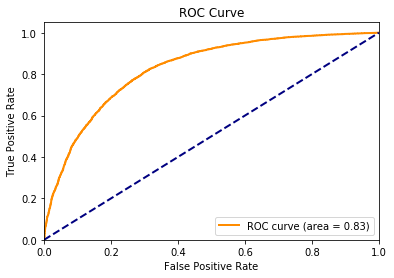

Iter 45150, Minibatch Loss= 0.454213, Training Accuracy= 0.80000
Iter 45300, Minibatch Loss= 0.292386, Training Accuracy= 0.93333
Iter 45450, Minibatch Loss= 0.769448, Training Accuracy= 0.46667
Iter 45600, Minibatch Loss= 0.520728, Training Accuracy= 0.86667
Iter 45750, Minibatch Loss= 0.499055, Training Accuracy= 0.93333
Validation Accuracy: 0.74696
Validation Loss: 0.53803295
Iter 45900, Minibatch Loss= 0.441690, Training Accuracy= 0.86667
Iter 46050, Minibatch Loss= 0.334355, Training Accuracy= 0.86667
Iter 46200, Minibatch Loss= 0.801985, Training Accuracy= 0.53333
Iter 46350, Minibatch Loss= 0.377858, Training Accuracy= 0.86667
Iter 46500, Minibatch Loss= 0.776777, Training Accuracy= 0.60000
Validation Accuracy: 0.72976
Validation Loss: 0.54672766
Iter 46650, Minibatch Loss= 0.537758, Training Accuracy= 0.80000
Iter 46800, Minibatch Loss= 0.341474, Training Accuracy= 0.80000
Iter 46950, Minibatch Loss= 0.439333, Training Accuracy= 0.73333
Iter 47100, Minibatch Loss= 0.304517, Tra

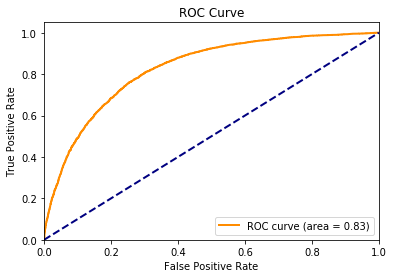

Iter 49650, Minibatch Loss= 0.469090, Training Accuracy= 0.73333
Iter 49800, Minibatch Loss= 0.530464, Training Accuracy= 0.80000
Iter 49950, Minibatch Loss= 0.548045, Training Accuracy= 0.73333
Iter 50100, Minibatch Loss= 0.351568, Training Accuracy= 1.00000
Iter 50250, Minibatch Loss= 0.572192, Training Accuracy= 0.66667
Validation Accuracy: 0.75216
Validation Loss: 0.52501035
Iter 50400, Minibatch Loss= 0.407704, Training Accuracy= 0.80000
Iter 50550, Minibatch Loss= 0.630954, Training Accuracy= 0.66667
Iter 50700, Minibatch Loss= 0.362671, Training Accuracy= 0.86667
Iter 50850, Minibatch Loss= 0.465354, Training Accuracy= 0.73333
Iter 51000, Minibatch Loss= 0.473924, Training Accuracy= 0.73333
Validation Accuracy: 0.74864
Validation Loss: 0.52028453
Iter 51150, Minibatch Loss= 0.665613, Training Accuracy= 0.73333
Iter 51300, Minibatch Loss= 0.440624, Training Accuracy= 0.86667
Iter 51450, Minibatch Loss= 0.494728, Training Accuracy= 0.80000
Iter 51600, Minibatch Loss= 0.454231, Tra

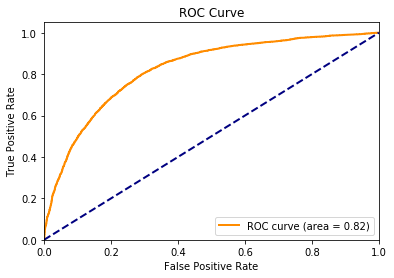

Iter 78150, Minibatch Loss= 0.435512, Training Accuracy= 0.86667
Iter 78300, Minibatch Loss= 0.453315, Training Accuracy= 0.80000
Iter 78450, Minibatch Loss= 0.574585, Training Accuracy= 0.73333
Iter 78600, Minibatch Loss= 0.380895, Training Accuracy= 0.86667
Iter 78750, Minibatch Loss= 0.410880, Training Accuracy= 0.86667
Validation Accuracy: 0.74928
Validation Loss: 0.52242357
Iter 78900, Minibatch Loss= 0.421402, Training Accuracy= 0.86667
Iter 79050, Minibatch Loss= 0.372407, Training Accuracy= 0.80000
Iter 79200, Minibatch Loss= 0.604548, Training Accuracy= 0.66667
Iter 79350, Minibatch Loss= 0.262567, Training Accuracy= 0.93333
Iter 79500, Minibatch Loss= 0.316790, Training Accuracy= 0.93333
Validation Accuracy: 0.74472
Validation Loss: 0.534213
Iter 79650, Minibatch Loss= 0.456476, Training Accuracy= 0.80000
Iter 79800, Minibatch Loss= 0.520514, Training Accuracy= 0.66667
Iter 79950, Minibatch Loss= 0.473813, Training Accuracy= 0.80000
Iter 80100, Minibatch Loss= 0.514273, Train

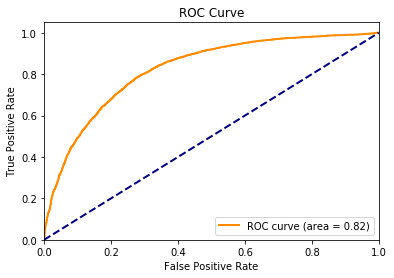

Iter 88650, Minibatch Loss= 0.655577, Training Accuracy= 0.66667
Iter 88800, Minibatch Loss= 0.466208, Training Accuracy= 0.80000
Iter 88950, Minibatch Loss= 0.578394, Training Accuracy= 0.80000
Iter 89100, Minibatch Loss= 0.426702, Training Accuracy= 0.80000
Iter 89250, Minibatch Loss= 0.591770, Training Accuracy= 0.80000
Validation Accuracy: 0.7268
Validation Loss: 0.60163134
Iter 89400, Minibatch Loss= 0.255000, Training Accuracy= 0.93333
Iter 89550, Minibatch Loss= 0.512050, Training Accuracy= 0.66667
Iter 89700, Minibatch Loss= 0.502737, Training Accuracy= 0.80000
Iter 89850, Minibatch Loss= 0.419529, Training Accuracy= 0.86667
Iter 90000, Minibatch Loss= 0.322021, Training Accuracy= 0.86667
Validation Accuracy: 0.74928
Validation Loss: 0.5404103
Iter 90150, Minibatch Loss= 0.365358, Training Accuracy= 0.93333
Iter 90300, Minibatch Loss= 0.350929, Training Accuracy= 0.86667
Iter 90450, Minibatch Loss= 0.355348, Training Accuracy= 0.86667
Iter 90600, Minibatch Loss= 0.284280, Train

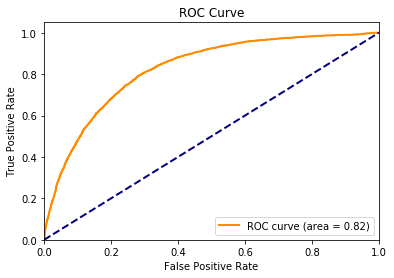

Iter 96150, Minibatch Loss= 0.562888, Training Accuracy= 0.80000
Iter 96300, Minibatch Loss= 0.517413, Training Accuracy= 0.86667
Iter 96450, Minibatch Loss= 0.436021, Training Accuracy= 0.80000
Iter 96600, Minibatch Loss= 0.331069, Training Accuracy= 0.86667
Iter 96750, Minibatch Loss= 0.507806, Training Accuracy= 0.60000
Validation Accuracy: 0.75096
Validation Loss: 0.5193242
Iter 96900, Minibatch Loss= 0.194922, Training Accuracy= 0.93333
Iter 97050, Minibatch Loss= 0.384697, Training Accuracy= 0.80000
Iter 97200, Minibatch Loss= 0.383264, Training Accuracy= 0.73333
Iter 97350, Minibatch Loss= 0.302618, Training Accuracy= 0.93333
Iter 97500, Minibatch Loss= 0.476447, Training Accuracy= 0.80000
Validation Accuracy: 0.74528
Validation Loss: 0.53575873
Iter 97650, Minibatch Loss= 0.268911, Training Accuracy= 0.93333
Iter 97800, Minibatch Loss= 0.404741, Training Accuracy= 0.80000
Iter 97950, Minibatch Loss= 0.669069, Training Accuracy= 0.60000
Iter 98100, Minibatch Loss= 0.437401, Trai

In [13]:
%%time

best_test_acc = -1.0
sess = tf.Session()

# Launch the graph
if True:
    sess.run(init)
    test_data, test_label, test_seqlen, test_dnn = dataset.get_test_batch()
    test_dict = {
        x: test_data, 
        y: test_label,
        seqlen: test_seqlen, 
        x2: test_dnn,
        lstm_keep_prob: 1.00,
        fc_keep_prob: 1.00
    }
    step = 1
    
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y, batch_seqlen, batch_dnn = dataset.next(batch_size)
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={
            x: batch_x, 
            y: batch_y,
            seqlen: batch_seqlen, 
            x2: batch_dnn,
            lstm_keep_prob: config.lstm_keep_prob,
            fc_keep_prob: config.fc_keep_prob
        })
        
        eval_dict = {
            x:      batch_x, 
            y:      batch_y,
            seqlen: batch_seqlen, 
            x2:     batch_dnn,
            lstm_keep_prob: 1.00,
            fc_keep_prob:   1.00
        }
        
        if should_log_metrics:
            acc = sess.run(accuracy, feed_dict=eval_dict)
            loss = sess.run(cost, feed_dict=eval_dict)
            line_start = str(step*batch_size) + ","
            train_loss_log.write(line_start + str(loss) + '\n')
            train_loss_log.flush()
            train_acc_log.write(line_start + str(acc) + '\n')
            train_acc_log.flush()

        if step % display_step == 0:
            if not should_log_metrics:
                acc = sess.run(accuracy, feed_dict=eval_dict)
                loss = sess.run(cost, feed_dict=eval_dict)
            print("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
            
        if step % (display_step) == 0:
            if should_log_metrics:
                test_acc = sess.run(accuracy, feed_dict=test_dict)
                test_loss = sess.run(cost, feed_dict=test_dict)
                test_loss_log.write(line_start + str(test_loss) + '\n')
                test_loss_log.flush()
                test_acc_log.write(line_start + str(test_acc) + '\n')
                test_acc_log.flush()        
            if step % (5 * display_step) == 0:
                if not should_log_metrics:
                    test_acc = sess.run(accuracy, feed_dict=test_dict)
                    test_loss = sess.run(cost, feed_dict=test_dict)
                print("Validation Accuracy:", test_acc)
                print("Validation Loss:", test_loss)
                
                if test_acc > best_test_acc:
                    best_test_acc = test_acc
                    # Plot ROC
                    answers = sess.run(tf.nn.softmax(logits), feed_dict=test_dict)
                    if label == 'good':
                        fpr, tpr, _ = roc_curve(1 - np.argmax(test_label, axis=1), answers[:, 0])
                    else:
                        fpr, tpr, _ = roc_curve(np.argmax(test_label, axis=1), answers[:, 1])
                    roc_auc = auc(fpr, tpr)
                    plt.figure()
                    lw = 2
                    plt.plot(fpr, tpr, color='darkorange',
                             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
                    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
                    plt.xlim([0.0, 1.0])
                    plt.ylim([0.0, 1.05])
                    plt.xlabel('False Positive Rate')
                    plt.ylabel('True Positive Rate')
                    plt.title('ROC Curve')
                    plt.legend(loc="lower right")
                    plt.savefig('plots/' + run_name + '_step_' + str(step) + '.png', dpi=300, bbox_inches='tight')
                    plt.show()
        
        if step % save_every == 0:
            save_path = saver.save(sess, save_fn)
            print("Checkpoint saved at %s" % save_path)
        step += 1
    print("Optimization Finished!")
    
    save_path = saver.save(sess, save_fn)
    print("Checkpoint saved at %s" % save_path)

    # Calculate accuracy
    print("Final Testing Accuracy:", sess.run(accuracy, feed_dict=test_dict))

### Read out the final weight matrix and save it to disk

In [14]:
w = sess.run(weights)
n_fc = len(fc_layer_sizes) + 1

for i in range(n_fc):
    f_name = 'weights/' + label + '_dim_' + str(i) + '.csv'
    np.savetxt(f_name, w[i], delimiter=',')